In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
import colorcet as cc
from adjustText import adjust_text

In [47]:
tf_e3_corrs = pd.read_pickle("pydata/tf_dependency_e3ls_expr_correlation_bylineage_dropna.pkl")

In [48]:
tf_e3_corrs.head()

,lineage,TF,E3_ligase,p-val,corr
0,Ampulla of Vater,TFAP2A,KDM2A,0.709839,-0.157329
1,Ampulla of Vater,TFAP2B,KDM2A,0.588720,0.227030
2,Ampulla of Vater,TFAP2C,KDM2A,0.195091,-0.511497
3,Ampulla of Vater,TFAP2D,KDM2A,0.350621,0.381823
4,Ampulla of Vater,TFAP2E,KDM2A,0.270403,-0.444031


In [49]:
tf_lin_filter = pd.read_pickle("pydata/tf_list_by_lineage.pkl")

In [50]:
tf_lin_filter.head()

,OncotreeLineage,TF,class
2999,Biliary Tract,AHR,Positive
3000,Biliary Tract,AIRE,Positive
3009,Biliary Tract,AR,Positive
3011,Biliary Tract,ARHGAP35,Positive
3028,Biliary Tract,ATF4,Negative


In [51]:
tf_lin_filter.rename(columns={"OncotreeLineage":"lineage"}, inplace=True)

In [52]:
tf_e3_corrs.shape

(20203650, 5)

In [53]:
tf_e3_corrs = pd.merge(left = tf_e3_corrs, right=tf_lin_filter, how="inner",
                       on=["TF", "lineage"]).rename(columns={"class": "TF-class"})

In [54]:
lineages = tf_e3_corrs["lineage"].unique()
tf_e3_corrs_fdrs = []
for lineage in lineages:
    lin_cors = tf_e3_corrs.loc[tf_e3_corrs["lineage"] == lineage].copy()
    lin_cors["fdr"] = fdrcorrection(lin_cors["p-val"].values)[1]
    tf_e3_corrs_fdrs.append(lin_cors)

In [55]:
tf_e3_corrs_fdrs = pd.concat(tf_e3_corrs_fdrs)

In [56]:
tf_e3_corrs_fdrs.head()

,lineage,TF,E3_ligase,p-val,corr,TF-class,fdr
0,Biliary Tract,AHR,KDM2A,0.989731,-0.002224,Positive,0.999027
1,Biliary Tract,HELT,KDM2A,0.403518,0.143569,Positive,0.936363
2,Biliary Tract,HEY2,KDM2A,0.548662,-0.103340,Positive,0.967295
3,Biliary Tract,HIF3A,KDM2A,0.015809,-0.399413,Positive,0.677130
4,Biliary Tract,MSGN1,KDM2A,0.475539,-0.122799,Positive,0.953853


In [57]:
tf_e3_corrs_fdrs["log10q"] = np.log10(tf_e3_corrs_fdrs["fdr"])*-1

In [58]:
tf_e3_corrs_fdrs.to_pickle("pydata/tf_dependency_e3ls_expr_correlation_bylineage_fdr.pkl")

In [59]:
len(lineages)

22

In [60]:
tf_e3_corrs_fdrs["name"] = tf_e3_corrs_fdrs["TF"] + "-" + tf_e3_corrs_fdrs["E3_ligase"]

In [61]:
tf_e3_corrs_fdrs.head()

,lineage,TF,E3_ligase,p-val,corr,TF-class,fdr,log10q,name
0,Biliary Tract,AHR,KDM2A,0.989731,-0.002224,Positive,0.999027,0.000423,AHR-KDM2A
1,Biliary Tract,HELT,KDM2A,0.403518,0.143569,Positive,0.936363,0.028556,HELT-KDM2A
2,Biliary Tract,HEY2,KDM2A,0.548662,-0.103340,Positive,0.967295,0.014441,HEY2-KDM2A
3,Biliary Tract,HIF3A,KDM2A,0.015809,-0.399413,Positive,0.677130,0.169328,HIF3A-KDM2A
4,Biliary Tract,MSGN1,KDM2A,0.475539,-0.122799,Positive,0.953853,0.020518,MSGN1-KDM2A


In [62]:
tf_e3_corrs_fdrs_significant = tf_e3_corrs_fdrs.loc[tf_e3_corrs_fdrs["fdr"]< 0.1]

In [63]:
tf_e3_corrs_fdrs_significant.to_pickle("pydata/tf_dependency_e3ls_expr_correlation_bylineage_fdr_significant.pkl")
tf_e3_corrs_fdrs_significant.to_csv("pydata/tf_dependency_e3ls_expr_correlation_bylineage_fdr_significant.csv")

In [64]:
tf_e3_corrs_fdrs_significant.head()

,lineage,TF,E3_ligase,p-val,corr,TF-class,fdr,log10q,name
14339,Biliary Tract,DMRT1,PDZRN3,5.360362e-06,0.678751,Positive,0.046343,1.334020,DMRT1-PDZRN3
14362,Biliary Tract,POU3F4,PDZRN3,7.373695e-08,0.760493,Positive,0.001039,2.983481,POU3F4-PDZRN3
14369,Biliary Tract,TP53,PDZRN3,3.209376e-08,0.773384,Positive,0.000603,3.219807,TP53-PDZRN3
27405,Biliary Tract,ZNF221,TRIM26,1.404946e-05,-0.655954,Positive,0.098961,1.004536,ZNF221-TRIM26
46539,Biliary Tract,DMRT1,KLHL10,6.492342e-07,0.722565,Positive,0.007317,2.135675,DMRT1-KLHL10


In [65]:
tf_e3_corrs_fdrs_significant.groupby(["lineage", "TF-class"]).count()

TF  E3_ligase  p-val  corr  fdr  log10q  name
lineage              TF-class                                                
Biliary Tract        Positive    8          8      8     8    8       8     8
Bone                 Negative    6          6      6     6    6       6     6
                     Positive   27         27     27    27   27      27    27
Bowel                Negative    1          1      1     1    1       1     1
                     Positive    6          6      6     6    6       6     6
Breast               Negative    3          3      3     3    3       3     3
                     Positive    1          1      1     1    1       1     1
CNS/Brain            Positive  309        309    309   309  309     309   309
Head and Neck        Negative    4          4      4     4    4       4     4
                     Positive    6          6      6     6    6       6     6
Lung                 Negative   21         21     21    21   21      21    21
                     Positive   12         12     12    12   12      12    12
Lymphoid             Negative   81         81     81    81   81      81    81
                     Positive   33         33     33    33   33      33    33
Myeloid              Negative    2          2      2     2    2       2     2
Ovary/Fallopian Tube Negative    1          1      1     1    1       1     1
                     Positive    7          7      7     7    7       7     7
Pancreas             Positive    1          1      1     1    1       1     1
Pleura               Positive    2          2      2     2    2       2     2
Prostate             Positive    7          7      7     7    7       7     7
Skin                 Negative   67         67     67    67   67      67    67
                     Positive   18         18     18    18   18      18    18
Uterus               Negative    1          1      1     1    1       1     1
                     Positive   11         11     11    11   11      11    11

In [66]:
def get_volcano_plot(l):
    plt.figure(figsize=(5,4))
    ax = plt.subplot(111)
    l_corr =tf_e3_corrs_fdrs.loc[tf_e3_corrs_fdrs["lineage"] == l] 
    sig_df = l_corr[l_corr["log10q"] > 1].sort_values(by=["fdr"]).iloc[0:20,:]
    sns.scatterplot(data=l_corr[l_corr["fdr"] > 0.1], x = "corr", y = "log10q", 
                    s = 1, color = "grey")
    sns.scatterplot(data=l_corr[l_corr["fdr"] < 0.1], x = "corr", y = "log10q", 
                    s = 3)
    text = []
    for i, row in sig_df.iterrows():
        text.append(plt.text(x =row["corr"], y = row["log10q"], s = row["name"], fontsize=6, 
                             ha='center', va='center')) 
    adjust_text(text, expand=(1.5, 1.5), arrowprops = dict(arrowstyle="-", color = "red", alpha=1, lw=0.2),
                x = sig_df["corr"], y = sig_df["log10q"])
    plt.title(l)
    ax.spines[['right', 'top']].set_visible(False)
    plt.xlabel("Pearson correlation")
    plt.ylabel("-log10(q-value)")
    plt.show()
    plt.clf()
    plt.close("all")

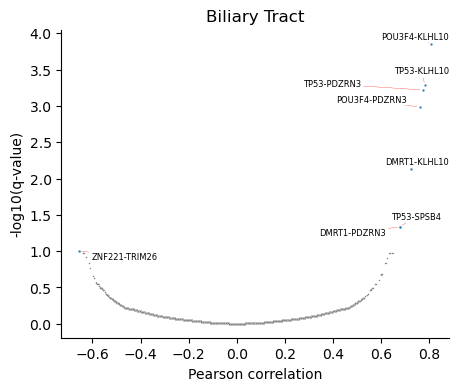

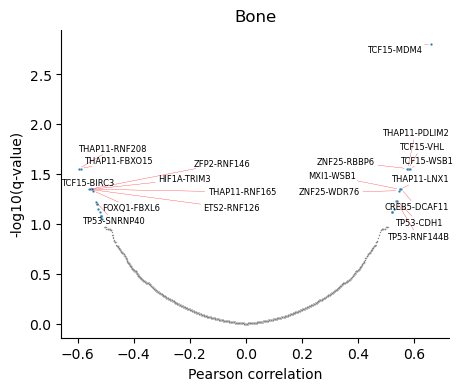

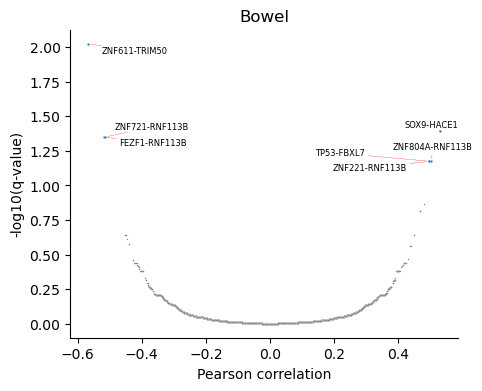

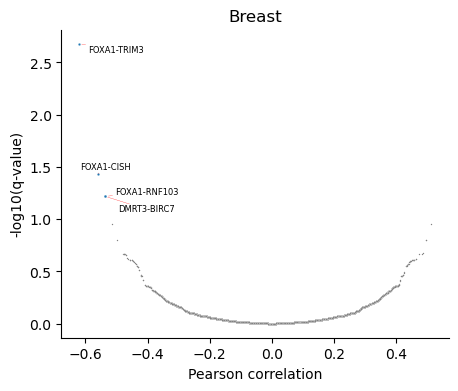

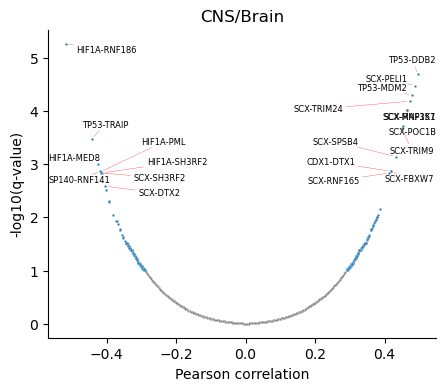

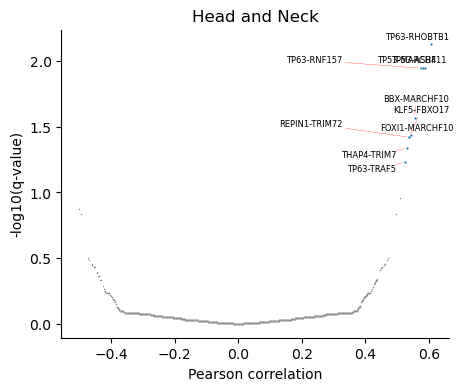

5 [ 0.520758   -0.66491989]
6 [ 0.87195337 -0.02027326]


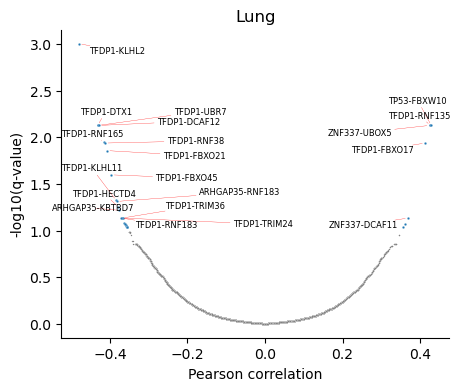

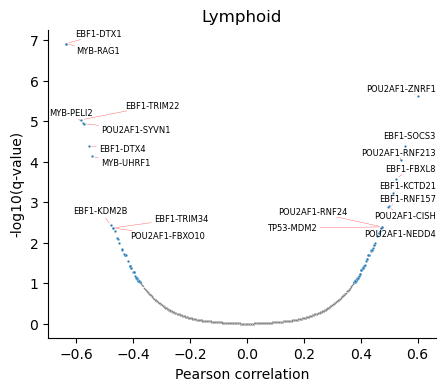

0 [-0.1880618  -0.79004261]
1 [-0.15351879  0.23866251]


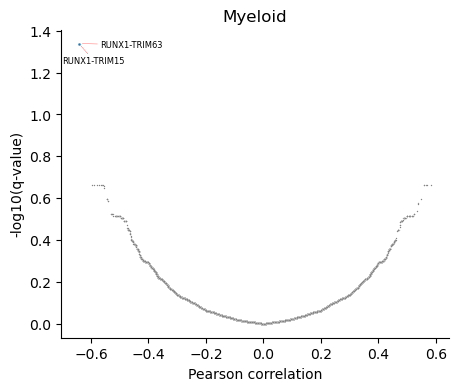

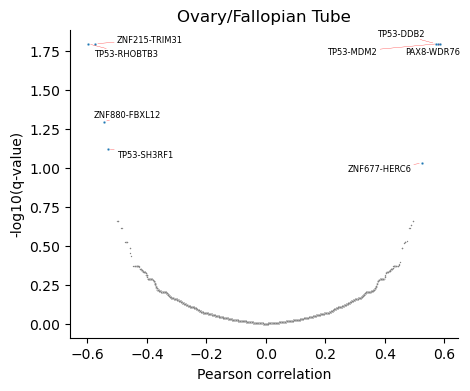

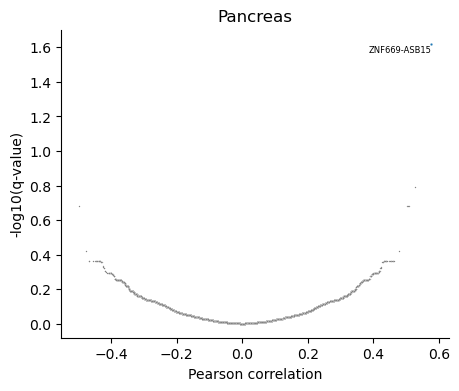

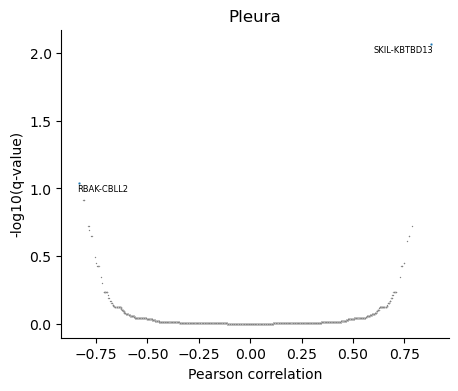

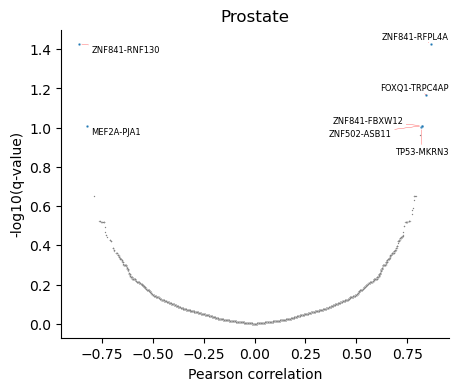

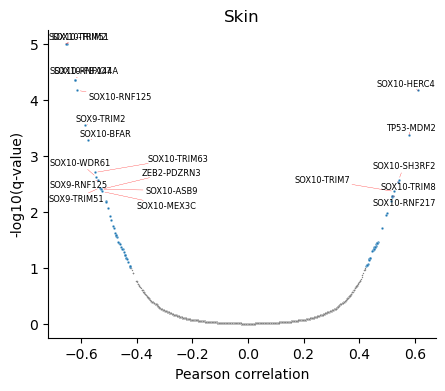

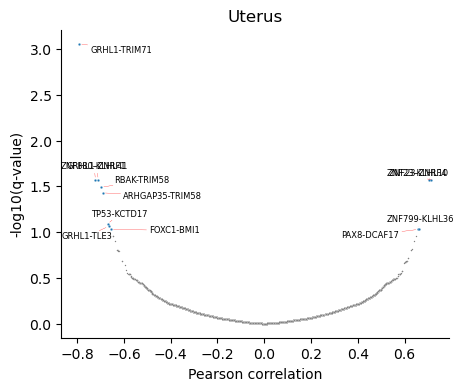

In [67]:
lineage_sig = tf_e3_corrs_fdrs_significant["lineage"].unique()
for lineage in lineage_sig:
    get_volcano_plot(lineage)